In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"  # specify which GPU(s) to be used
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from pylab import rcParams

In [2]:
def plot_relative_distribution(df, feature, hue, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    total = float(len(df))
    sns.countplot(x=feature, hue=hue, data=df, palette='Set2')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

In [3]:
fold = 1
mode = "curriculum_easy_10idx"
df = pd.read_csv(f"./Train_Data_{mode}_{fold}.csv")
df.head()

,image_id,data_provider,isup_grade,gleason_score,tile_number,split,tile_pixel,tile_blueratio,image_idx,k_means_grp,curicullum_cluster_grp
0,9716b5d2e13a28be3dc836134153720c,radboud,4,4+4,7,1.0,"121,109,111,86,81,79,77,","48,40,46,33,32,33,28,",0,1,1
1,0954f0bb123cf3be8b00c9c989dcf3d6,karolinska,0,0+0,43,1.0,"152,141,135,134,127,128,128,123,126,122,117,11...","47,41,43,40,45,44,39,43,45,43,48,42,40,33,41,3...",1,0,2
2,d861180850ca54282b38c782734a7dc7,karolinska,0,0+0,39,0.0,"89,82,72,67,70,69,69,60,61,69,68,69,58,57,60,6...","32,30,29,29,25,27,26,26,26,25,25,25,26,25,26,2...",2,4,0
3,459154b1334d073cfef8af95362a7051,karolinska,0,0+0,34,1.0,"112,103,102,99,92,89,97,90,94,88,83,83,82,79,7...","42,34,40,33,37,31,38,31,33,33,29,30,33,31,30,2...",3,6,0
4,27489a7f1972687cccb1258116ff7f10,karolinska,0,0+0,24,0.0,"105,101,101,92,87,85,84,89,86,83,81,77,73,80,7...","34,35,37,35,32,31,32,29,31,29,31,28,28,29,27,2...",4,0,2


### Noisy samples in the training

In [4]:
ranked_stats = np.load(f"../Step4_Training/runs/train_ranked_sample_loss_{fold}_{mode}.npy")
ranked_stats.shape ## [:; index, provider, epochs]

(744, 42)

In [5]:
df_temp = df.loc[ranked_stats[:,0].astype(int)]
df_temp.head()

,image_id,data_provider,isup_grade,gleason_score,tile_number,split,tile_pixel,tile_blueratio,image_idx,k_means_grp,curicullum_cluster_grp
7102,fc8bbe93363ee983d99c949f41ea180f,karolinska,5,5+4,37,0.0,"80,79,77,72,75,68,68,61,59,67,69,54,57,62,65,6...","28,28,27,27,27,25,26,26,25,26,25,25,25,25,25,2...",7102,6,1
3783,2fdcb544b8c07838dd6bbc0b609e80b6,karolinska,4,4+4,45,0.0,"74,75,71,69,68,63,70,60,65,57,61,51,54,62,60,5...","31,28,28,28,27,27,26,26,25,26,25,24,25,24,24,2...",3783,4,1
3625,3077b49eba93c24a339086c57db4edc1,radboud,2,3+4,47,0.0,"96,104,93,96,92,96,91,83,95,101,91,97,87,80,89...","34,38,33,30,30,36,33,29,33,37,32,33,30,30,34,3...",3625,3,0
2071,fa34632030552cff40da1c0cffe3ab81,karolinska,2,3+4,27,0.0,"97,93,91,87,84,85,84,87,84,84,79,76,74,70,70,7...","32,31,30,31,30,31,30,30,31,29,28,29,29,27,29,2...",2071,11,2
5605,ef8cb1391e62cb6721eddf6e3495087d,radboud,3,4+3,58,2.0,"107,101,95,93,88,92,88,85,83,78,82,76,74,67,76...","35,36,33,31,30,31,31,29,28,27,29,27,29,28,27,3...",5605,6,0


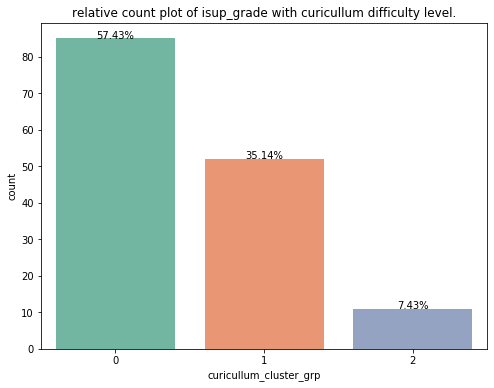

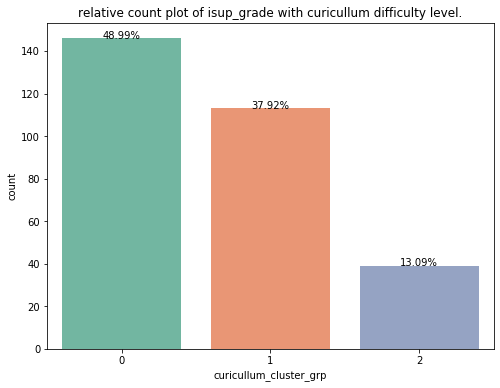

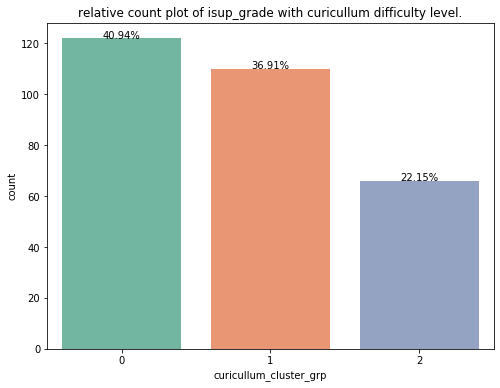

In [6]:
plotrange = [0, 0.2, 0.6, 1]
for i in range(1, len(plotrange)):
    start, end = int(plotrange[i-1] * len(df_temp)), int(plotrange[i] * len(df_temp))
    df_temp_ = df_temp[start:end]
    plot_relative_distribution(df=df_temp_, feature='curicullum_cluster_grp', hue=None, 
                                   title = f'relative count plot of isup_grade with curicullum difficulty level.', 
                                   size=2)

### Large entropy in unlabeled data

In [33]:
ranked_stats = np.load(f"../Step4_Training/runs/unlabel_ranked_sample_entropy_{fold}_{mode}.npy")
ranked_stats.shape ## [:; index, provider, epochs]

(4000, 42)

In [34]:
df_temp = df.loc[ranked_stats[:,0].astype(int)]
df_temp.head()

,image_id,data_provider,isup_grade,gleason_score,tile_number,split,tile_pixel,tile_blueratio,image_idx,k_means_grp,curicullum_cluster_grp
7434,60502735df319ec33f862579fb6563d5,karolinska,0,0+0,1,1.0,"62,","24,",7434,1,2
3270,b28f0f94ebc50f79d1b03cf0c0baa335,radboud,0,negative,4,3.0,"82,78,47,66,","31,32,24,26,",3270,7,2
8672,f187290ba0d588d11f47467ec93ce202,radboud,5,4+5,11,2.0,"110,113,107,104,96,103,97,84,75,71,55,","43,48,41,40,36,39,36,31,29,27,25,",8672,2,1
6981,886682be4f834c17abfcbd5137374279,radboud,0,negative,3,3.0,"79,84,65,","33,31,27,",6981,1,2
2345,dec45a32f96c496a9141d49617286870,radboud,0,negative,6,1.0,"69,52,61,51,57,24,","25,23,25,22,24,19,",2345,11,2


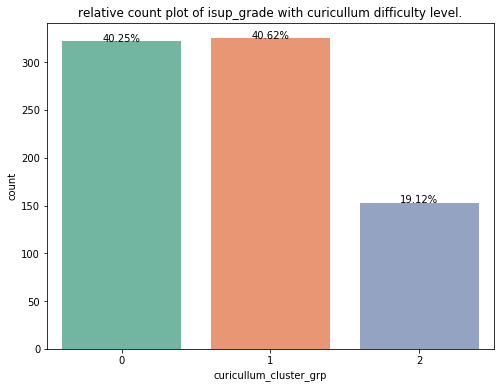

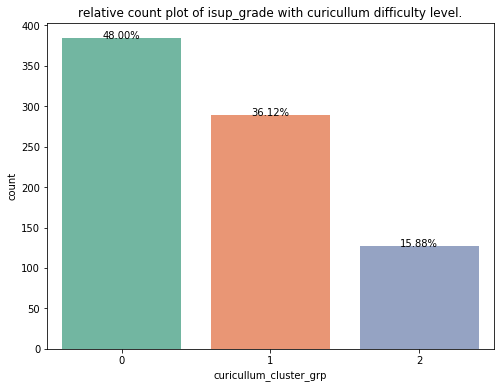

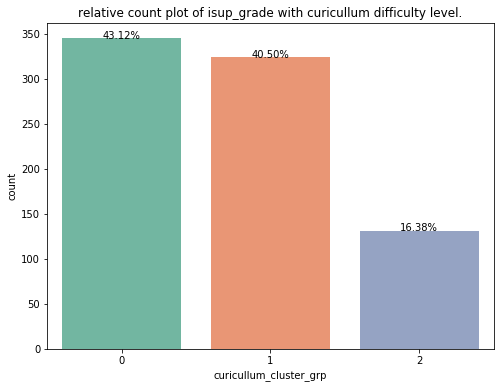

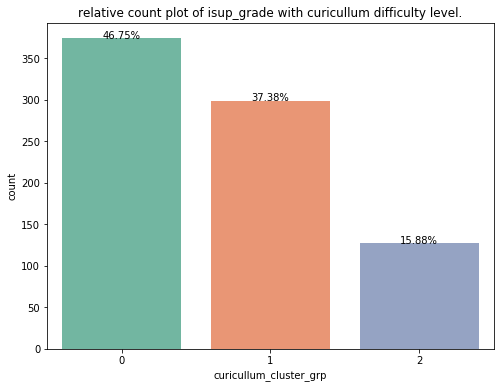

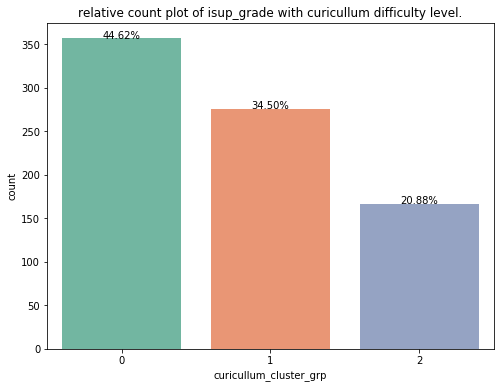

In [37]:
plotrange = [0, 0.2, 0.4, 0.6, 0.8, 1]
for i in range(1, len(plotrange)):
    start, end = int(plotrange[i-1] * len(df_temp)), int(plotrange[i] * len(df_temp))
    df_temp_ = df_temp[start:end]
    plot_relative_distribution(df=df_temp_, feature='curicullum_cluster_grp', hue=None, 
                                   title = f'relative count plot of isup_grade with curicullum difficulty level.', 
                                   size=2)